In [2]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import sklearn
import itertools

from google.colab.patches import cv2_imshow
from google.colab import files
from skimage import io
from PIL import Image

import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16

In [4]:
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/dataset/UTKFace.tar" -C "/content"     #[run this cell to extract tar files]

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [5]:
df_images = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataframe/image_classes_summary.csv')
df_images['age_intuit_class'].value_counts().sort_index()

0     1123
1     1044
2     1246
3     1180
4    11881
5     4544
6     2690
Name: age_intuit_class, dtype: int64

In [6]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_intuit_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

# Fine Tuning

With fine tuning, I intend to look 
* Optimize hyperparameters by adding regularization
* Observe different batch size, resize images, learning rates
* Retrain the last convolutional and classification layer

It is also well known in the machine learning community the difficulty of making general statements about the effects of hyperparameters as behavior often varies from dataset to dataset and model to model. 

Therefore, the conclusions we make can only serve as signposts rather than general statements.


## Resize Image
The architecture of VGG16 was trained on a 224 x 224 x 3 image. I'm curious to know if resizing to the original size would increase accuracy.

In [6]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0     786
1     731
2     872
3     826
4    8316
5    3181
6    1883
Name: age_intuit_class, dtype: int64

In [7]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.047378
1    0.044004
2    0.052580
3    0.049768
4    0.501195
5    0.191621
6    0.113454
Name: age_intuit_class, dtype: float64

In [8]:
X_train.head()

,filename,age
4551,/content/UTKFace/9_0_0_20170110215523228.jpg.c...,9
15986,/content/UTKFace/5_0_3_20161220222937859.jpg.c...,5
21544,/content/UTKFace/25_1_0_20170116001327790.jpg....,25
20814,/content/UTKFace/30_1_2_20170116162552501.jpg....,30
20894,/content/UTKFace/29_1_2_20170104021748445.jpg....,29


In [275]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [276]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [277]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [278]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [282]:
# Final model
final_model = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (224, 224, 3)
    )
final_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [283]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = final_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model = tf.keras.Model(final_model.input, x)
# We compile the model
final_model.compile(optimizer=Adam(learning_rate=0.001, decay=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Layer input_28 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                

In [284]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [285]:
# Fitting the model.

final_model_history = final_model.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        callbacks=early_stop,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 41s 617ms/step - loss: 30.6577 - accuracy: 0.5459 - val_loss: 0.9265 - val_accuracy: 0.6596
Epoch 2/30
65/65 [==============================] - 40s 615ms/step - loss: 0.8821 - accuracy: 0.6741 - val_loss: 0.8498 - val_accuracy: 0.6828
Epoch 3/30
65/65 [==============================] - 40s 617ms/step - loss: 0.7346 - accuracy: 0.7221 - val_loss: 0.8262 - val_accuracy: 0.6949
Epoch 4/30
65/65 [==============================] - 40s 617ms/step - loss: 0.6311 - accuracy: 0.7546 - val_loss: 0.8133 - val_accuracy: 0.7020
Epoch 5/30
65/65 [==============================] - 40s 618ms/step - loss: 0.5500 - accuracy: 0.7861 - val_loss: 0.8204 - val_accuracy: 0.7079
Epoch 6/30
65/65 [==============================] - 40s 617ms/step - loss: 0.4965 - accuracy: 0.8054 - val_loss: 0.8198 - val_accuracy: 0.7093
Epoch 7/30
65/65 [==============================] - 40s 618ms/step - loss: 0.4466 - accuracy: 0.8239 - val_loss: 0.8188 - val_accuracy: 0.709

In [258]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_history.history['loss']
test_loss = final_model_history.history['val_loss']
train_accuracy = final_model_history.history['accuracy']
test_accuracy = final_model_history.history['val_accuracy']

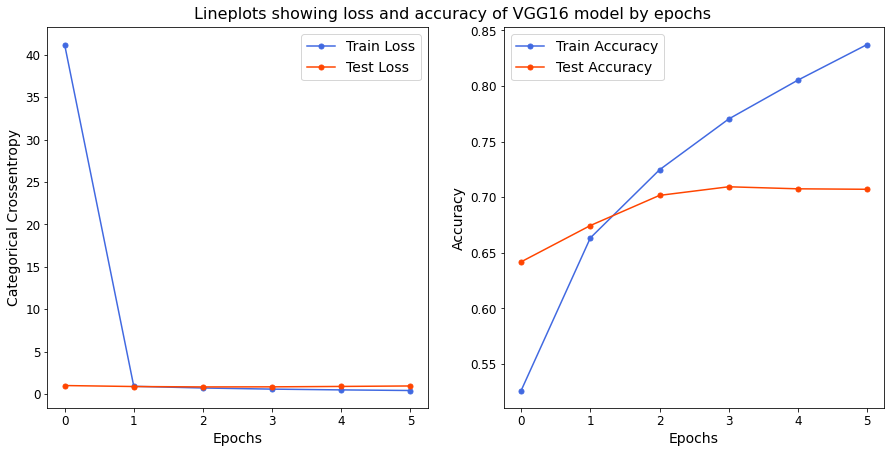

In [259]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model_resize_image_loss_accuracy.png', bbox_inches='tight');

There doesn't seem to be much difference in test accuracy and loss compared when the image size was 200 x 200. The plot also shows the accuracy was on its way to be overfitted. I conclude from here that resizing the image did not improve the model.

It could be that a difference of 4 pixels was only a marginal difference. Even if there was an improvement, it was not seen.

In [260]:
# Evaluating the model on test dataset.

final_model_score = final_model.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 12s 425ms/step - loss: 0.9465 - accuracy: 0.7072


In [261]:
# Printing the relevant score summary.

final_model_labels = final_model.metrics_names
print(f'final_model resize {final_model_labels[0]} \t= {round(final_model_score[0], 3)}')
print(f'final_model resize {final_model_labels[1]} \t= {round(final_model_score[1], 3)}')

final_model resize loss 	= 0.947
final_model resize accuracy 	= 0.707


In [262]:
# Generating predictions from the model above.

final_model_pred = final_model.predict(test_dataset)
final_model_pred = final_model_pred.argmax(axis=-1)

In [263]:
len(final_model_pred)

7113

In [264]:
final_model_pred_cm = confusion_matrix(test_labels_list, final_model_pred)
final_model_pred_cm

array([[ 258,   73,    1,    0,    4,    0,    1],
       [  87,  166,   39,    1,   18,    2,    0],
       [   8,   60,  124,   37,  138,    5,    2],
       [   0,    1,   32,   71,  243,    6,    1],
       [   3,    3,    3,   17, 3367,  169,    3],
       [   0,    0,    0,    3,  664,  660,   36],
       [   0,    0,    0,    2,   95,  326,  384]])

Normalized confusion matrix


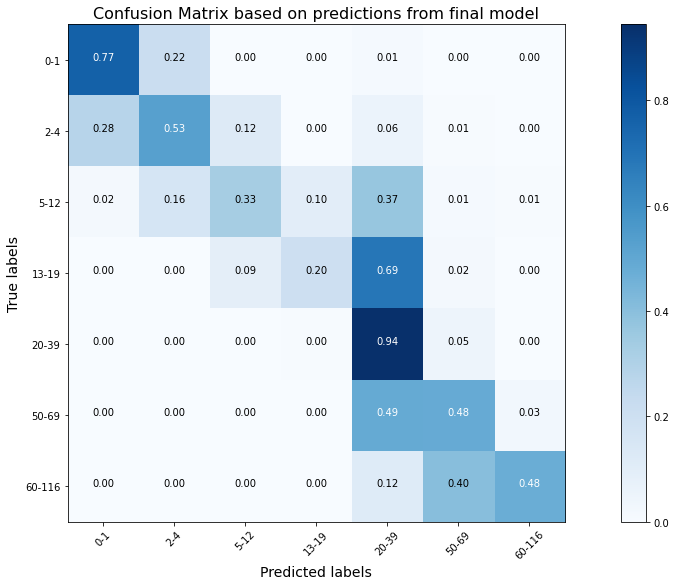

In [265]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_resize_cm_normalized"
                     )

plt.show()

On a note, it is observed that the 13-19 age is severly missclassfied to be 20-39. Hope to improve this while tweaking the rest of the parameters

Confusion matrix, without normalization


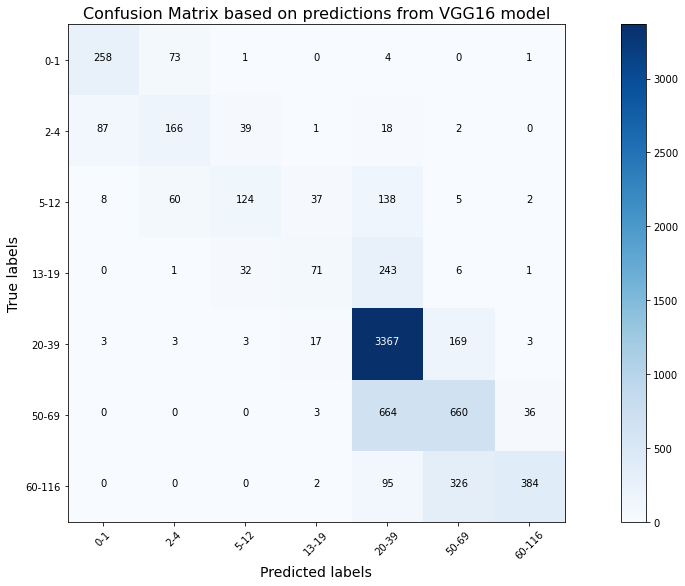

In [266]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_resize_cm"
                     )

plt.show()

## Batch Size

Batch size is one of the most important hyperparameters to tune in modern deep learning systems. Practitioners often want to use a larger batch size to train their model as it allows computational speedups from the parallelism of GPUs. However, it is said in this [article](https://arxiv.org/pdf/1705.08741.pdf) that too large of a batch size will lead to poor generalization.

In my external reseatch, using smaller batch sizes have been shown to have faster convergence to “good” accuracy, as smaller batch sizes allow the model to “start learning before having to see all the data.” The downside of using a smaller batch size is that the model is not guaranteed to converge to the global optimal.

We will explore different batch sizes and hopefully find the most optimum

**Testing batch sizes(64, 128, 256, 512)**

In [312]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [313]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [314]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    #image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [315]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [316]:
# Final model
final_model_2 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
final_model_2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [317]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model_2.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = final_model_2.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model_2 = tf.keras.Model(final_model_2.input, x)
# We compile the model
final_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
final_model_2.summary()

Layer input_31 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                

In [318]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [319]:
# Fitting the model.

final_model_2_history = final_model_2.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        callbacks=early_stop,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 63s 731ms/step - loss: 19.0267 - accuracy: 0.5211 - val_loss: 0.9534 - val_accuracy: 0.6416
Epoch 2/30
65/65 [==============================] - 35s 541ms/step - loss: 0.8889 - accuracy: 0.6619 - val_loss: 0.8613 - val_accuracy: 0.6672
Epoch 3/30
65/65 [==============================] - 35s 542ms/step - loss: 0.7056 - accuracy: 0.7261 - val_loss: 0.8176 - val_accuracy: 0.6920
Epoch 4/30
65/65 [==============================] - 35s 543ms/step - loss: 0.5721 - accuracy: 0.7729 - val_loss: 0.8292 - val_accuracy: 0.6966
Epoch 5/30
65/65 [==============================] - 35s 543ms/step - loss: 0.4772 - accuracy: 0.8089 - val_loss: 0.8458 - val_accuracy: 0.7041
Epoch 6/30
65/65 [==============================] - 35s 542ms/step - loss: 0.4057 - accuracy: 0.8406 - val_loss: 0.8927 - val_accuracy: 0.7031
Epoch 00006: early stopping


In [320]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_2_history.history['loss']
test_loss = final_model_2_history.history['val_loss']
train_accuracy = final_model_2_history.history['accuracy']
test_accuracy = final_model_2_history.history['val_accuracy']

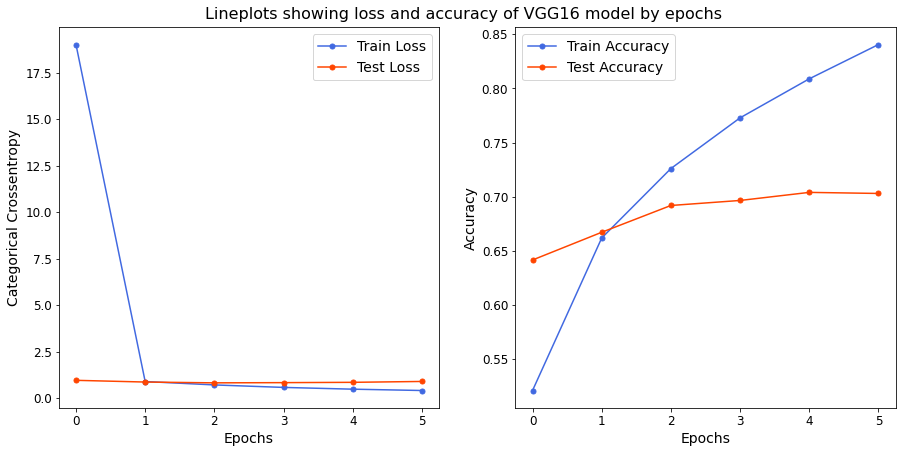

In [321]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model_batch_size_loss_accuracy.png', bbox_inches='tight');

In [322]:
# Evaluating the model on test dataset.

final_model_2_score = final_model_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 373ms/step - loss: 0.8927 - accuracy: 0.7031


In [323]:
# Printing the relevant score summary.

final_model_2_labels = final_model_2.metrics_names
print(f'final_model batchsize {final_model_2_labels[0]} \t= {round(final_model_2_score[0], 3)}')
print(f'final_model batchsize {final_model_2_labels[1]} \t= {round(final_model_2_score[1], 3)}')

final_model batchsize loss 	= 0.893
final_model batchsize accuracy 	= 0.703


In [324]:
# Generating predictions from the model above.

final_model_2_pred = final_model_2.predict(test_dataset)
final_model_2_pred = final_model_2_pred.argmax(axis=-1)

In [325]:
len(final_model_2_pred)

7113

In [326]:
final_model_2_pred_cm = confusion_matrix(test_labels_list, final_model_2_pred)
final_model_2_pred_cm

array([[ 276,   55,    3,    0,    2,    0,    1],
       [ 110,  131,   53,    2,   17,    0,    0],
       [   8,   41,  163,   25,  128,    5,    4],
       [   0,    0,   43,   42,  261,    7,    1],
       [   3,    3,   21,    8, 3191,  318,   21],
       [   0,    0,    0,    5,  501,  662,  195],
       [   0,    0,    0,    1,   61,  209,  536]])

Normalized confusion matrix


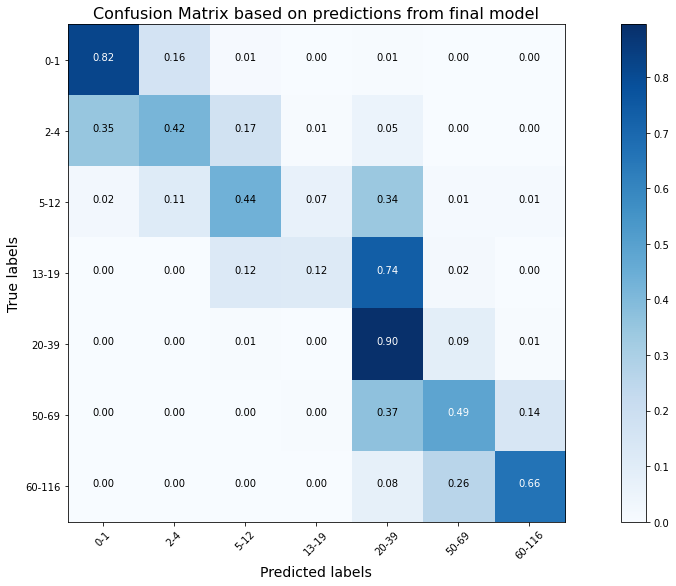

In [327]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_2_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_batchsize_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


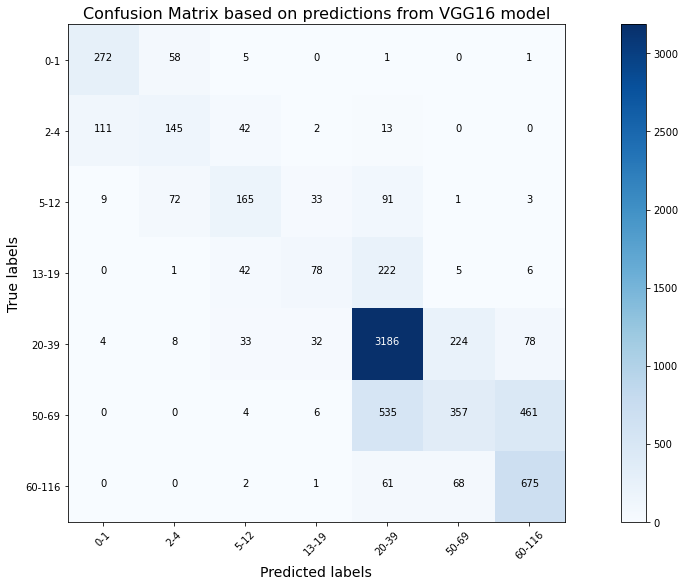

In [302]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_2_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_batchsize_cm"
                     )

plt.show()

|Batch Size|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
64|4 of 30|0.5531|0.9092|77.92%|68.58%
128|5 of 30|0.4955|0.8936|79.88%|69.76%
256|6 of 30|0.4057|0.8927|84.06%|70.31%
512|9 of 30|0.4015|0.8205|84.09%|70.45%

As observed by the above table, there is a slight increase to the test accuracy as the batch size increases. However, the overfitting is exponentially bigger. With this, I have decided to stick with 256 as a batch size as I did not see any benefits of a larger batch size.

## Learning Rate

The amount of change to the model during each step of this search process, or the step size, is called the “learning rate” and provides perhaps the most important hyperparameter to tune.

With that, I will be testing out the learning rate with the dataset optimized at batch size = 256.

**Testing learning rate(0.0005, 0.0001, 0.001, 0.01)**

In [369]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [370]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [371]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    #image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [372]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [373]:
# Final model
final_model_3 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
final_model_3.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [374]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model_3.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = final_model_3.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model_3 = tf.keras.Model(final_model_3.input, x)
# We compile the model
final_model_3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
final_model_3.summary()

Layer input_36 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                

In [375]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [376]:
# Fitting the model.

final_model_3_history = final_model_3.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        callbacks=early_stop,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 36s 546ms/step - loss: 7.3997 - accuracy: 0.4454 - val_loss: 3.8779 - val_accuracy: 0.5826
Epoch 2/30
65/65 [==============================] - 35s 540ms/step - loss: 4.5448 - accuracy: 0.5525 - val_loss: 3.1878 - val_accuracy: 0.5982
Epoch 3/30
65/65 [==============================] - 35s 541ms/step - loss: 3.4244 - accuracy: 0.6001 - val_loss: 2.7888 - val_accuracy: 0.6228
Epoch 4/30
65/65 [==============================] - 35s 542ms/step - loss: 2.6513 - accuracy: 0.6298 - val_loss: 2.5430 - val_accuracy: 0.6276
Epoch 5/30
65/65 [==============================] - 35s 543ms/step - loss: 2.1853 - accuracy: 0.6582 - val_loss: 2.3653 - val_accuracy: 0.6280
Epoch 6/30
65/65 [==============================] - 35s 543ms/step - loss: 1.7462 - accuracy: 0.6859 - val_loss: 2.2095 - val_accuracy: 0.6293
Epoch 7/30
65/65 [==============================] - 35s 543ms/step - loss: 1.4719 - accuracy: 0.7105 - val_loss: 2.0994 - val_accuracy: 0.6349

In [377]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_3_history.history['loss']
test_loss = final_model_3_history.history['val_loss']
train_accuracy = final_model_3_history.history['accuracy']
test_accuracy = final_model_3_history.history['val_accuracy']

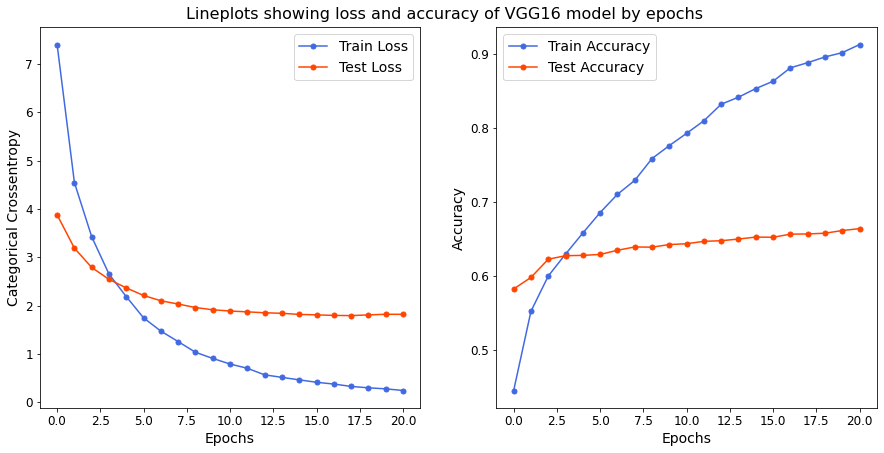

In [378]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model_learning_rate_loss_accuracy.png', bbox_inches='tight');

In [379]:
# Evaluating the model on test dataset.

final_model_3_score = final_model_3.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 374ms/step - loss: 1.8192 - accuracy: 0.6641


In [380]:
# Printing the relevant score summary.

final_model_3_labels = final_model_3.metrics_names
print(f'final_model_3 learningrate {final_model_3_labels[0]} \t= {round(final_model_3_score[0], 3)}')
print(f'final_model_3 learningrate {final_model_3_labels[1]} \t= {round(final_model_3_score[1], 3)}')

final_model_3 learningrate loss 	= 1.819
final_model_3 learningrate accuracy 	= 0.664


In [381]:
# Generating predictions from the model above.

final_model_3_pred = final_model_3.predict(test_dataset)
final_model_3_pred = final_model_3_pred.argmax(axis=-1)

In [382]:
len(final_model_3_pred)

7113

In [383]:
final_model_3_pred_cm = confusion_matrix(test_labels_list, final_model_3_pred)
final_model_3_pred_cm

array([[ 239,   76,   12,    3,    6,    0,    1],
       [ 105,  116,   58,    6,   26,    1,    1],
       [  18,   38,  132,   57,  112,   10,    7],
       [   0,    4,   43,   71,  219,   11,    6],
       [   3,   10,   23,   61, 3125,  306,   37],
       [   2,    3,    9,   20,  592,  569,  168],
       [   1,    0,    5,    4,   91,  234,  472]])

Normalized confusion matrix


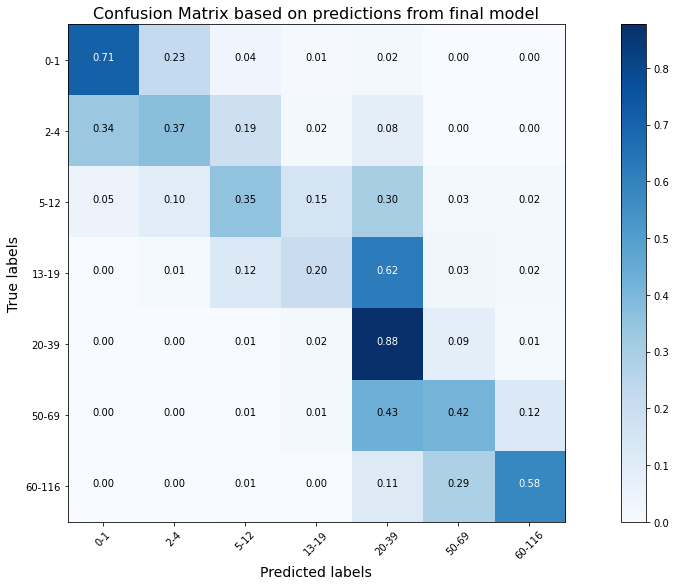

In [384]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_3_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_learningrate_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


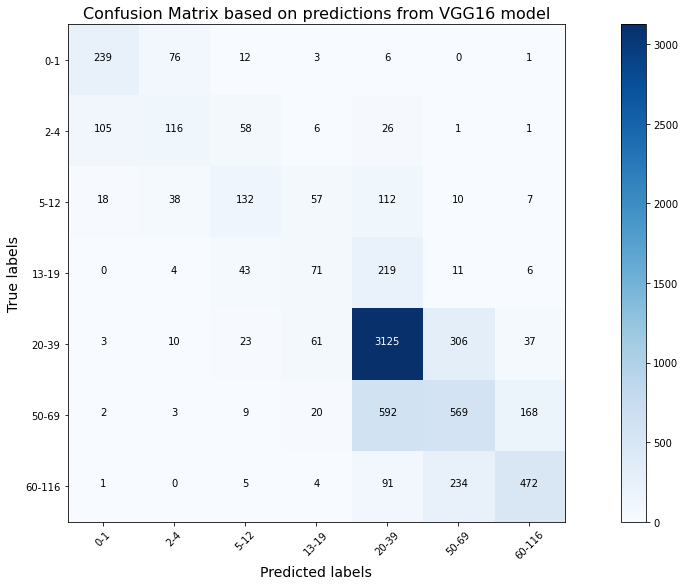

In [385]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_3_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_learningrate_cm"
                     )

plt.show()

|Learning Rate|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
0.00001|21 of 30|0.2435|1.8192|91.29%|66.41%
0.0001|6 of 30|0.1404|1.2777|95.27%|67.48%
0.0005|6 of 30|0.3016|0.9377|88.27%|70.42%
0.001|6 of 30|0.4569|0.8088|81.72%|70.80%
0.01|9 of 30|0.9638|1.0427|63.56%|60.90%

As can be observed, the most optimal learning rate using the optimizer adam was LR = 0.001, with 70.80% test accuracy with a reasonable 81.72% train accuracy. 

## Unfreeze last one Conv2D layer of VGG16

In the neural network, the first layers detect simpler and more general patterns, while the more advance in the architecture, the more complicated the patterns they detect.
Hence, I will retrain the last convolutional stage before the classification stage to see if there are any improvements to the model.

In [15]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [16]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [17]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    #image_resized = tf.image.resize(image_decoded, [48, 48])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [18]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [36]:
# Final model
final_model_4 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
final_model_4.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [37]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model_4.layers: 
  if layer.name == 'block5_conv3':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = final_model_4.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model_4 = tf.keras.Model(final_model_4.input, x)
# We compile the model
final_model_4.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
final_model_4.summary()

Layer input_4 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 bloc

In [38]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [40]:
# Fitting the model.


final_model_4_history = final_model_4.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        callbacks=early_stop,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 36s 549ms/step - loss: 0.7953 - accuracy: 0.6818 - val_loss: 0.8779 - val_accuracy: 0.6653
Epoch 2/30
65/65 [==============================] - 36s 552ms/step - loss: 0.7355 - accuracy: 0.7075 - val_loss: 0.8962 - val_accuracy: 0.6653
Epoch 3/30
65/65 [==============================] - 36s 550ms/step - loss: 0.7183 - accuracy: 0.7141 - val_loss: 0.8819 - val_accuracy: 0.6646
Epoch 4/30
65/65 [==============================] - 36s 552ms/step - loss: 0.6866 - accuracy: 0.7237 - val_loss: 0.8738 - val_accuracy: 0.6759
Epoch 5/30
65/65 [==============================] - 36s 552ms/step - loss: 0.6579 - accuracy: 0.7360 - val_loss: 0.9452 - val_accuracy: 0.6591
Epoch 6/30
65/65 [==============================] - 36s 553ms/step - loss: 0.6357 - accuracy: 0.7448 - val_loss: 1.0292 - val_accuracy: 0.6532
Epoch 7/30
65/65 [==============================] - 36s 551ms/step - loss: 0.6174 - accuracy: 0.7513 - val_loss: 0.9234 - val_accuracy: 0.6800

In [41]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_4_history.history['loss']
test_loss = final_model_4_history.history['val_loss']
train_accuracy = final_model_4_history.history['accuracy']
test_accuracy = final_model_4_history.history['val_accuracy']

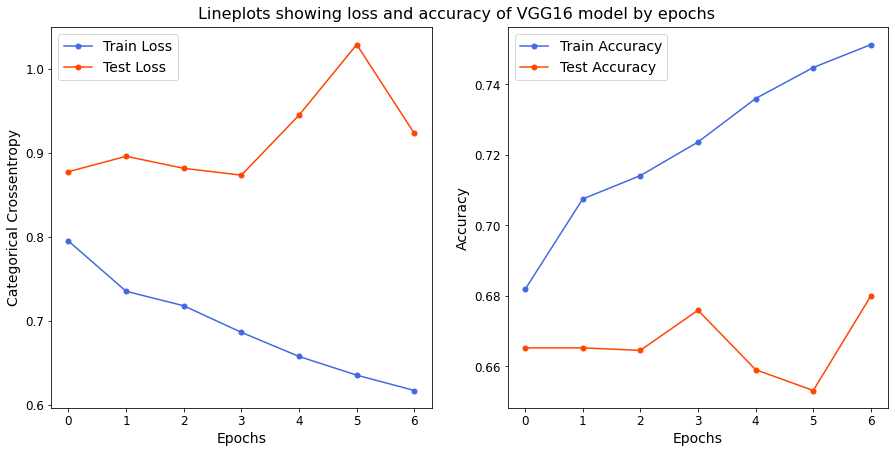

In [42]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model_optimzer_SGD_loss_accuracy.png', bbox_inches='tight');

In [43]:
# Evaluating the model on test dataset.

final_model_4_score = final_model_4.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 373ms/step - loss: 0.9234 - accuracy: 0.6800


In [44]:
# Printing the relevant score summary.

final_model_4_labels = final_model_4.metrics_names
print(f'final_model_4 unfreeze layer {final_model_4_labels[0]} \t= {round(final_model_4_score[0], 3)}')
print(f'final_model_4 unfreeze layer {final_model_4_labels[1]} \t= {round(final_model_4_score[1], 3)}')

final_model_4 unfreeze layer loss 	= 0.923
final_model_4 unfreeze layer accuracy 	= 0.68


In [45]:
# Generating predictions from the model above.

final_model_4_pred = final_model_4.predict(test_dataset)
final_model_4_pred = final_model_4_pred.argmax(axis=-1)

In [46]:
len(final_model_4_pred)

7113

In [47]:
final_model_4_pred_cm = confusion_matrix(test_labels_list, final_model_4_pred)
final_model_4_pred_cm

array([[ 199,  120,    6,    1,    9,    1,    1],
       [  72,  151,   66,    3,   20,    1,    0],
       [   0,   46,  165,   39,  112,    6,    6],
       [   0,    4,   38,   69,  235,    5,    3],
       [   2,    4,   22,   59, 3194,  268,   16],
       [   0,    0,    7,    8,  589,  642,  117],
       [   0,    2,    1,    2,   80,  305,  417]])

Normalized confusion matrix


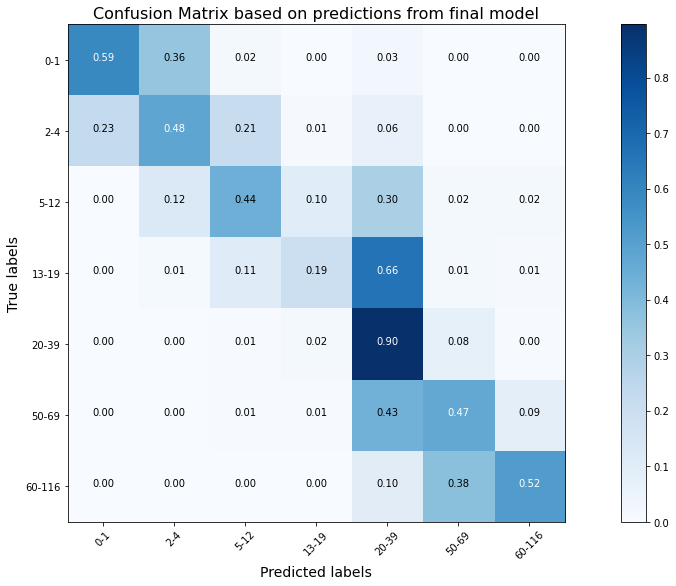

In [48]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_4_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_optimizer_SGD_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


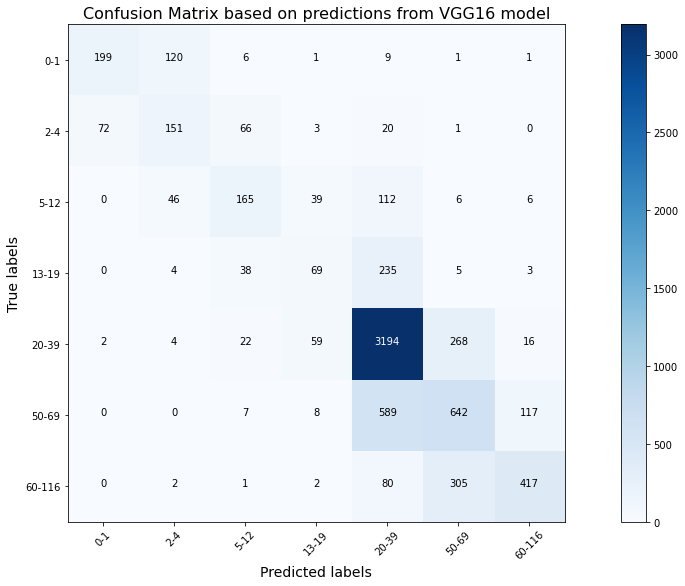

In [50]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_4_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_optimizer_SGD_cm"
                     )

plt.show()

No Improvements were noticed. The first few epochs, the testing accuracy was already at 68%, and the training accuracy started to overfit. We will try unfreezing the last 2 Conv2D layers next.

## Unfreeze last 2 Conv2D layer of VGG16

In [51]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [52]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [53]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    #image_resized = tf.image.resize(image_decoded, [48, 48])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [54]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [55]:
# Final model
final_model_5 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
final_model_5.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [56]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model_5.layers: 
  if layer.name == 'block5_conv2':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = final_model_5.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model_5 = tf.keras.Model(final_model_5.input, x)
# We compile the model
final_model_5.compile(
    optimizer=SGD(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
final_model_5.summary()

Layer input_5 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (No

In [57]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [58]:
# Fitting the model.


final_model_5_history = final_model_5.fit(train_dataset,
                        batch_size=128,
                        validation_data=test_dataset,
                        callbacks=early_stop,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 37s 562ms/step - loss: 2.3152 - accuracy: 0.4580 - val_loss: 1.2683 - val_accuracy: 0.5671
Epoch 2/30
65/65 [==============================] - 36s 561ms/step - loss: 1.2094 - accuracy: 0.5708 - val_loss: 1.0945 - val_accuracy: 0.6085
Epoch 3/30
65/65 [==============================] - 37s 563ms/step - loss: 1.0690 - accuracy: 0.6113 - val_loss: 1.0041 - val_accuracy: 0.6242
Epoch 4/30
65/65 [==============================] - 36s 562ms/step - loss: 0.9893 - accuracy: 0.6315 - val_loss: 0.9543 - val_accuracy: 0.6460
Epoch 5/30
65/65 [==============================] - 37s 562ms/step - loss: 0.9294 - accuracy: 0.6482 - val_loss: 1.0130 - val_accuracy: 0.6280
Epoch 6/30
65/65 [==============================] - 36s 562ms/step - loss: 0.8876 - accuracy: 0.6592 - val_loss: 0.9440 - val_accuracy: 0.6525
Epoch 7/30
65/65 [==============================] - 37s 563ms/step - loss: 0.8473 - accuracy: 0.6735 - val_loss: 0.8718 - val_accuracy: 0.6724

In [83]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_5_history.history['loss']
test_loss = final_model_5_history.history['val_loss']
train_accuracy = final_model_5_history.history['accuracy']
test_accuracy = final_model_5_history.history['val_accuracy']

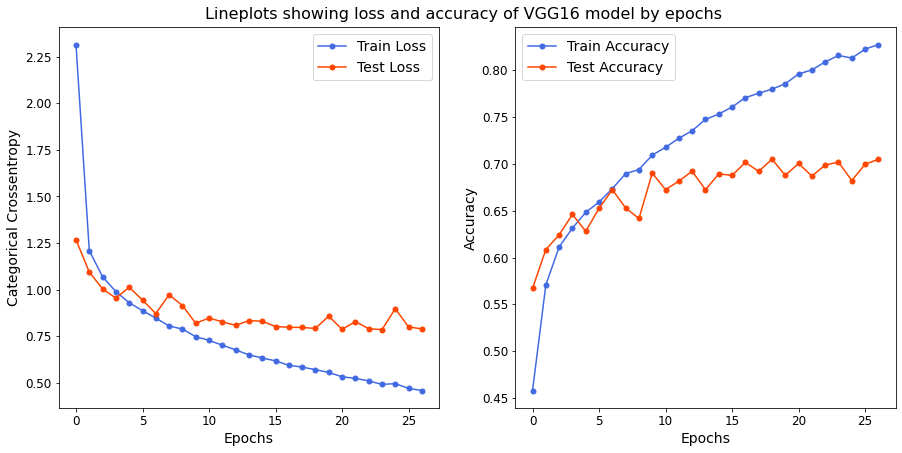

In [84]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model_freeze_all_layers_optimzer_SGD_loss_accuracy.png', bbox_inches='tight');

Started overfitting in the first few epochs, subsequently at around 15 epochs, the test accuracy was hovering around 70%. In my opinion, this was quite satisfactory.

In [61]:
# Evaluating the model on test dataset.

final_model_5_score = final_model_5.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 372ms/step - loss: 0.7896 - accuracy: 0.7048


In [62]:
# Printing the relevant score summary.

final_model_5_labels = final_model_5.metrics_names
print(f'final_model_5 optimizer {final_model_5_labels[0]} \t= {round(final_model_5_score[0], 3)}')
print(f'final_model_5 optimizer {final_model_5_labels[1]} \t= {round(final_model_5_score[1], 3)}')

final_model_5 optimizer loss 	= 0.79
final_model_5 optimizer accuracy 	= 0.705


In [63]:
# Generating predictions from the model above.

final_model_5_pred = final_model_5.predict(test_dataset)
final_model_5_pred = final_model_5_pred.argmax(axis=-1)

In [64]:
len(final_model_5_pred)

7113

In [65]:
final_model_5_pred_cm = confusion_matrix(test_labels_list, final_model_5_pred)
final_model_5_pred_cm

array([[ 240,   85,    4,    0,    7,    0,    1],
       [  78,  165,   47,    3,   16,    3,    1],
       [   7,   50,  186,   38,   85,    5,    3],
       [   1,    2,   55,   64,  223,    7,    2],
       [   0,    3,   15,   32, 3209,  279,   27],
       [   0,    0,    3,    7,  540,  624,  189],
       [   0,    0,    0,    2,   68,  212,  525]])

Normalized confusion matrix


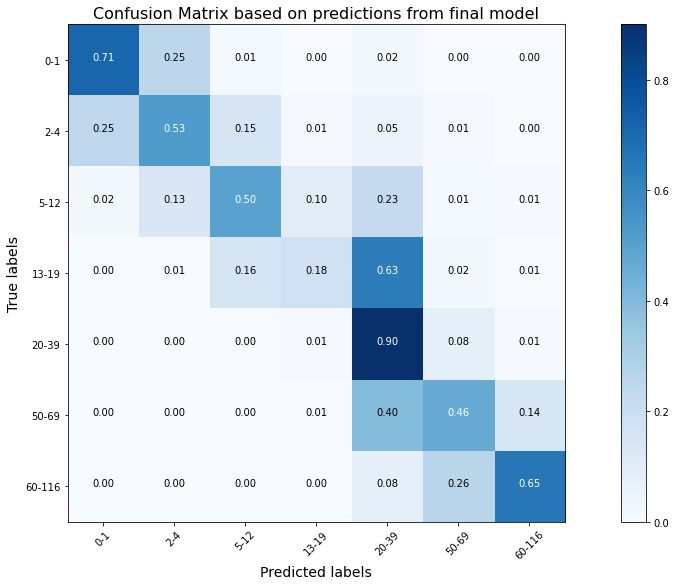

In [66]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_5_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_freeze_2_conv_layers__SGD_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


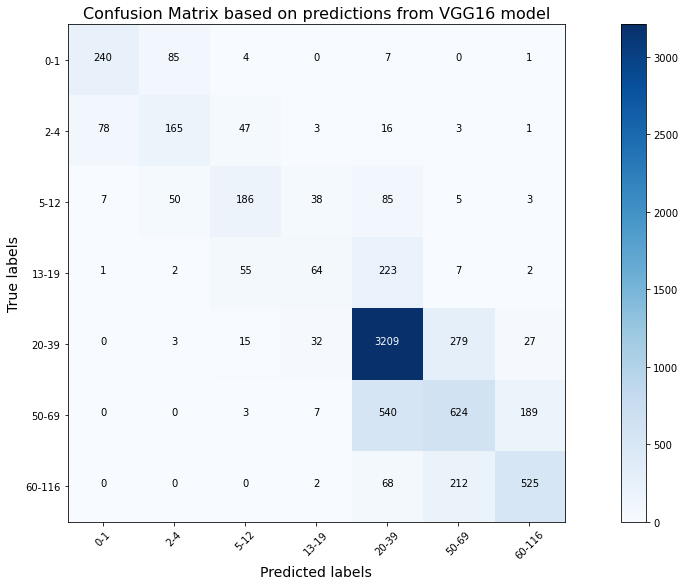

In [68]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_5_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_freeze_2_conv_layers__SGD_cm"
                     )

plt.show()

## Add Avg Pooling before Classification Layer

In [73]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [74]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [75]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [224, 224])
    #image_rescaled = image_resized.append(np)
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [76]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [77]:
# Final model
final_model_6 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (224, 224, 3),
    pooling='avg'
    )
final_model_6.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [80]:
# Use a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
    )

# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model_6.layers: 
  if layer.name == 'block5_conv2':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

# We insert a preprocessing layer for rescaling input shape
# We take the last layer of our the model and add it to our classifier
last = final_model_6.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model_6 = tf.keras.Model(final_model_6.input, x)
# We compile the model
final_model_6.compile(
    optimizer=SGD(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
final_model_6.summary()

Layer input_6 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (No

In [81]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [82]:
# Fitting the model.


final_model_6_history = final_model_6.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        callbacks=early_stop,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 89s 1s/step - loss: 1.6411 - accuracy: 0.4826 - val_loss: 1.2334 - val_accuracy: 0.5647
Epoch 2/30
65/65 [==============================] - 42s 644ms/step - loss: 1.2529 - accuracy: 0.5549 - val_loss: 1.1034 - val_accuracy: 0.6002
Epoch 3/30
65/65 [==============================] - 42s 645ms/step - loss: 1.1391 - accuracy: 0.5835 - val_loss: 1.0274 - val_accuracy: 0.6266
Epoch 4/30
65/65 [==============================] - 42s 645ms/step - loss: 1.0665 - accuracy: 0.6061 - val_loss: 0.9775 - val_accuracy: 0.6362
Epoch 5/30
65/65 [==============================] - 42s 645ms/step - loss: 1.0129 - accuracy: 0.6223 - val_loss: 0.9411 - val_accuracy: 0.6457
Epoch 6/30
65/65 [==============================] - 42s 645ms/step - loss: 0.9804 - accuracy: 0.6303 - val_loss: 0.9127 - val_accuracy: 0.6513
Epoch 7/30
65/65 [==============================] - 42s 646ms/step - loss: 0.9434 - accuracy: 0.6390 - val_loss: 0.8909 - val_accuracy: 0.6596
Ep

In [85]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_6_history.history['loss']
test_loss = final_model_6_history.history['val_loss']
train_accuracy = final_model_6_history.history['accuracy']
test_accuracy = final_model_6_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of VGG16 model by epochs')

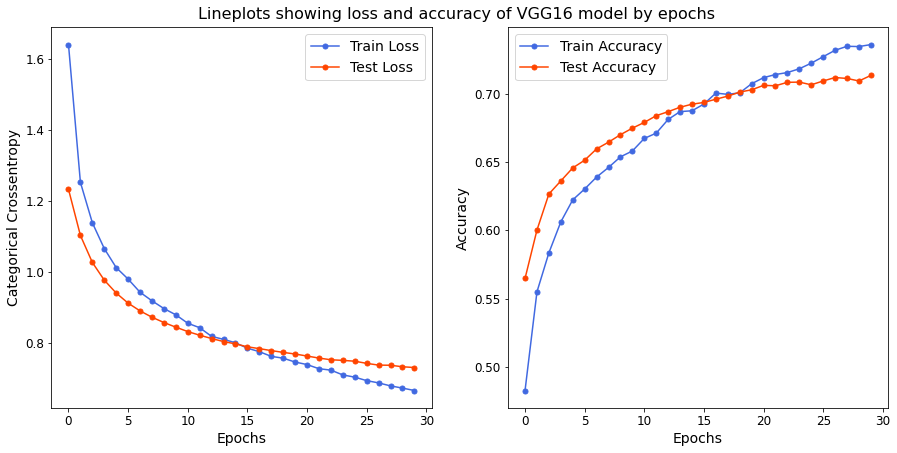

In [86]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
#plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model_freeze_all_layers_optimzer_SGD_loss_accuracy.png', bbox_inches='tight');

In [87]:
# Evaluating the model on test dataset.

final_model_6_score = final_model_6.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 12s 420ms/step - loss: 0.7313 - accuracy: 0.7135


In [88]:
# Printing the relevant score summary.

final_model_6_labels = final_model_6.metrics_names
print(f'Add avg pooling {final_model_6_labels[0]} \t= {round(final_model_6_score[0], 3)}')
print(f'Add avg pooling {final_model_6_labels[1]} \t= {round(final_model_6_score[1], 3)}')

Add avg pooling loss 	= 0.731
Add avg pooling accuracy 	= 0.713


In [89]:
# Generating predictions from the model above.

final_model_6_pred = final_model_6.predict(test_dataset)
final_model_6_pred = final_model_6_pred.argmax(axis=-1)

In [90]:
len(final_model_6_pred)

7113

In [91]:
final_model_6_pred_cm = confusion_matrix(test_labels_list, final_model_6_pred)
final_model_6_pred_cm

array([[ 279,   51,    1,    0,    4,    0,    2],
       [ 134,  114,   46,    1,   17,    1,    0],
       [  13,   55,  163,   32,  101,    3,    7],
       [   0,    1,   41,   56,  245,    8,    3],
       [   1,    4,   15,   15, 3208,  298,   24],
       [   0,    0,    1,    2,  465,  690,  205],
       [   1,    0,    0,    0,   40,  201,  565]])

Normalized confusion matrix


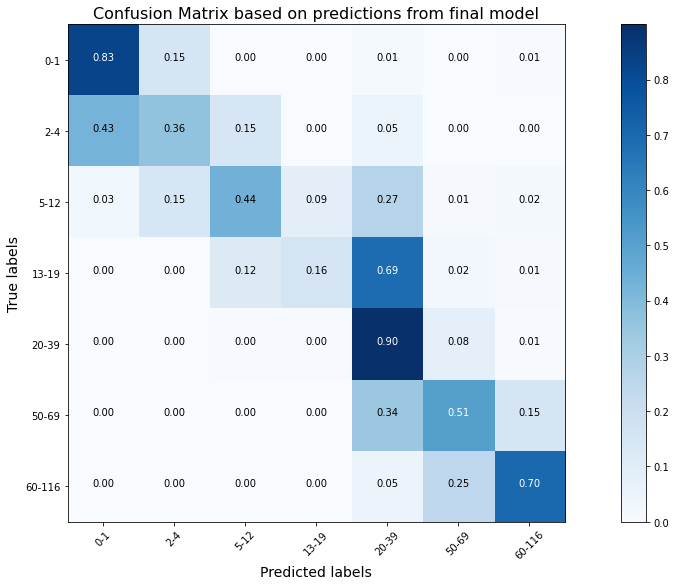

In [92]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_6_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_Avg_Pooling_SGD_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


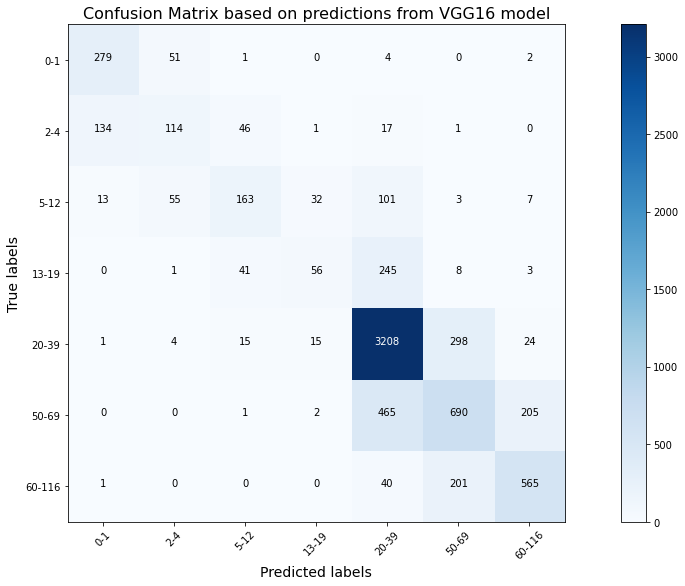

In [94]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_6_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_Avg_Pooling_SGD_cm"
                     )

plt.show()

# Final Model

In [19]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [20]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [21]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [224, 224])
    #image_rescaled = image_resized.append(np)
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [22]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [23]:
# Final model
final_model_7 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (224, 224, 3),
    pooling='avg'
    )
final_model_7.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in final_model_7.layers: 
  if layer.name == 'block5_conv2':
    break
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

# We insert a preprocessing layer for rescaling input shape
# We take the last layer of our the model and add it to our classifier
last = final_model_7.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
final_model_7 = tf.keras.Model(final_model_7.input, x)
# We compile the model
final_model_7.compile(
    optimizer=SGD(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
final_model_7.summary()

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (No

In [25]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/Colab Notebooks/logs/age/final_age_model")

In [27]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/Colab Notebooks/models/age/final_age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [28]:
# Fitting the model.


final_model_7_history = final_model_7.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        callbacks=[tensorboard,checkpoint],
                        epochs=80,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/80
65/65 [==============================] - ETA: 0s - loss: 1.6887 - accuracy: 0.4671
Epoch 00001: val_accuracy improved from -inf to 0.56376, saving model to /content/drive/My Drive/Colab Notebooks/models/age/final_age_model_checkpoint.h5
65/65 [==============================] - 53s 801ms/step - loss: 1.6887 - accuracy: 0.4671 - val_loss: 1.2021 - val_accuracy: 0.5638
Epoch 2/80
65/65 [==============================] - ETA: 0s - loss: 1.2504 - accuracy: 0.5548
Epoch 00002: val_accuracy improved from 0.56376 to 0.60593, saving model to /content/drive/My Drive/Colab Notebooks/models/age/final_age_model_checkpoint.h5
65/65 [==============================] - 51s 790ms/step - loss: 1.2504 - accuracy: 0.5548 - val_loss: 1.0775 - val_accuracy: 0.6059
Epoch 3/80
65/65 [==============================] - ETA: 0s - loss: 1.1372 - accuracy: 0.5848
Epoch 00003: val_accuracy improved from 0.60593 to 0.62688, saving model to /content/drive/My Drive/Colab Notebooks/models/age/final_age_model_

In [29]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_model_7_history.history['loss']
test_loss = final_model_7_history.history['val_loss']
train_accuracy = final_model_7_history.history['accuracy']
test_accuracy = final_model_7_history.history['val_accuracy']

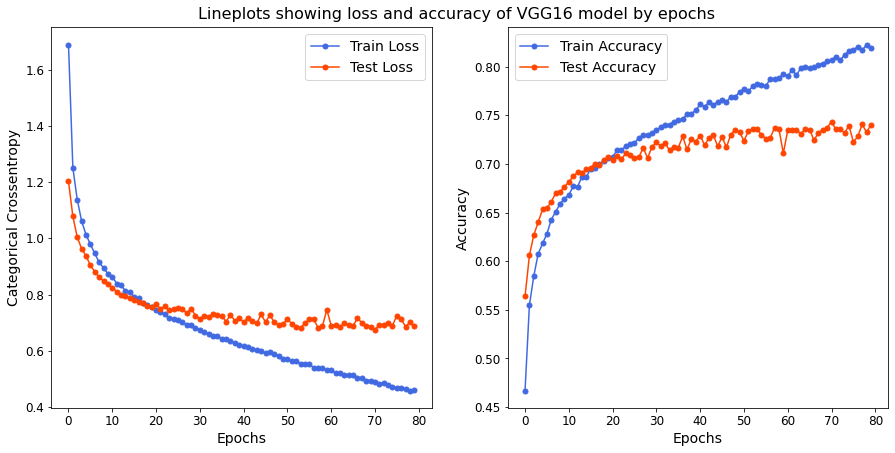

In [30]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/final_model.png', bbox_inches='tight');

In [38]:
# Evaluating the model on test dataset.

final_model_7_score = final_model_7.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 12s 420ms/step - loss: 0.6864 - accuracy: 0.7399


In [40]:
# Printing the relevant score summary.

final_model_7_labels = final_model_7.metrics_names
print(f'Final Model {final_model_7_labels[0]} \t= {round(final_model_7_score[0], 3)}')
print(f'Final Model {final_model_7_labels[1]} \t= {round(final_model_7_score[1], 3)}')

Final Model loss 	= 0.686
Final Model accuracy 	= 0.74


In [41]:
# Generating predictions from the model above.

final_model_7_pred = final_model_7.predict(test_dataset)
final_model_7_pred = final_model_7_pred.argmax(axis=-1)

In [42]:
len(final_model_7_pred)

7113

In [43]:
final_model_7_pred_cm = confusion_matrix(test_labels_list, final_model_7_pred)
final_model_7_pred_cm

array([[ 253,   76,    3,    1,    2,    0,    2],
       [  85,  156,   57,    3,    9,    3,    0],
       [   8,   45,  219,   38,   60,    2,    2],
       [   0,    1,   44,  121,  186,    1,    1],
       [   0,    2,   17,   41, 3327,  166,   12],
       [   0,    0,    3,    8,  561,  666,  125],
       [   0,    1,    0,    0,   50,  235,  521]])

Normalized confusion matrix


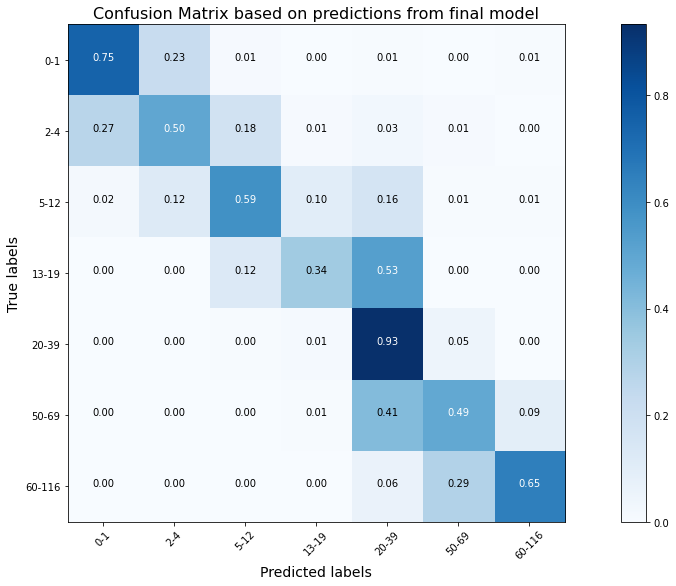

In [39]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_7_pred_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from final model",
                      export_as="final_model_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


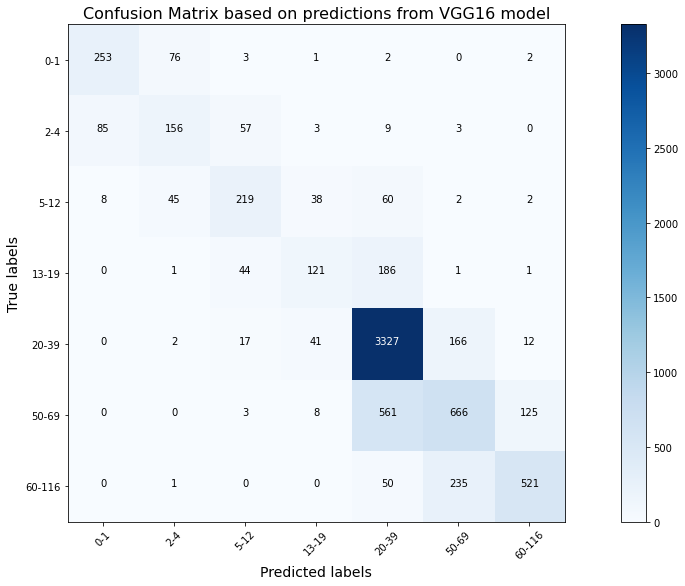

In [37]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(final_model_7_pred_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="final_model_cm"
                     )

plt.show()

# Summary Table of Accuracy and Loss Scores

|Resize|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
224x224|7 of 30|0.4466|0.8188|82.39%|70.98%

|Batch Size|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
64|4 of 30|0.5531|0.9092|77.92%|68.58%
128|5 of 30|0.4955|0.8936|79.88%|69.76%
256|6 of 30|0.4057|0.8927|84.06%|70.31%
512|9 of 30|0.4015|0.8205|84.09%|70.45%

|Learning Rate|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
0.00001|21 of 30|0.2435|1.8192|91.29%|66.41%
0.0001|6 of 30|0.1404|1.2777|95.27%|67.48%
0.0005|6 of 30|0.3016|0.9377|88.27%|70.42%
0.001|6 of 30|0.4569|0.8088|81.72%|70.80%
0.01|9 of 30|0.9638|1.0427|63.56%|60.90%

|Layers|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|
Unfreeze 1|7 of 30|0.6174|0.9234|75.13%|68.00%
Unfreeze 2|27 of 30|0.4587|0.7896|82.73%|70.48%
Add Global Avg Pool|30 of 30|0.6666|0.7313|73.61%|71.35%

**Final Model**

|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|
7 of 30|0.4900|0.6749|80.69%|74.34%

# Conclusion
* Getting from an accuracy of 38.68% to 74.34% was no easy feat. I assumed that each parameter is independent of each other, hence taking an iterative approach towards a better score. But I've learned that the hyperparameters were not independent of each other, and there would be a better way to approach training the model
* Transfer learning from the VGG16 model immediately performed better than the base CNN model. It also trains faster as the weights have already be initialized.
* Model is sensitive to small changes, especially for classes with small datasets. 

# Further Improvements

* As the classes with more data trained better generally, I would add more image datasets to complement the current, believe it would yield better results.

* Use the tensorboard to compare the accuracy and loss plots. It will also allow me to deep dive into the layers that matter.

* Train data on more advanced models that are better than VGG16. Also, possibly train on advanced models that have similar dataset with UTKFace.

* Preprocess the training data, to make data similar to original model's train dataset. 

